In [1]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
feature_names = diabetes.feature_names

df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

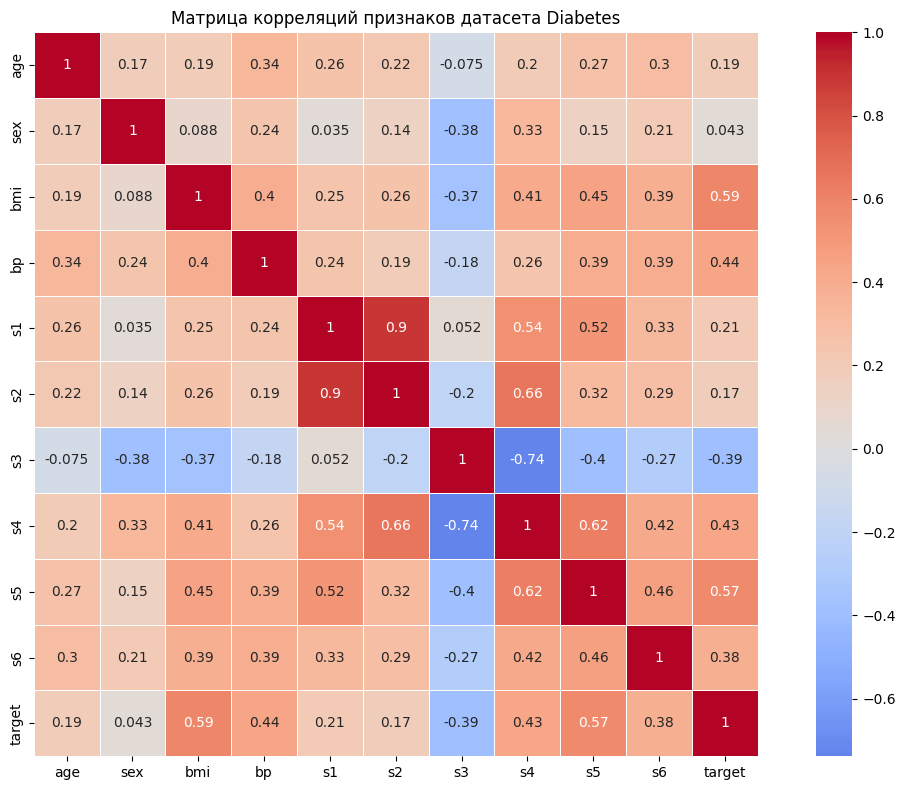

In [2]:
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Матрица корреляций признаков датасета Diabetes')
plt.tight_layout()
plt.show()

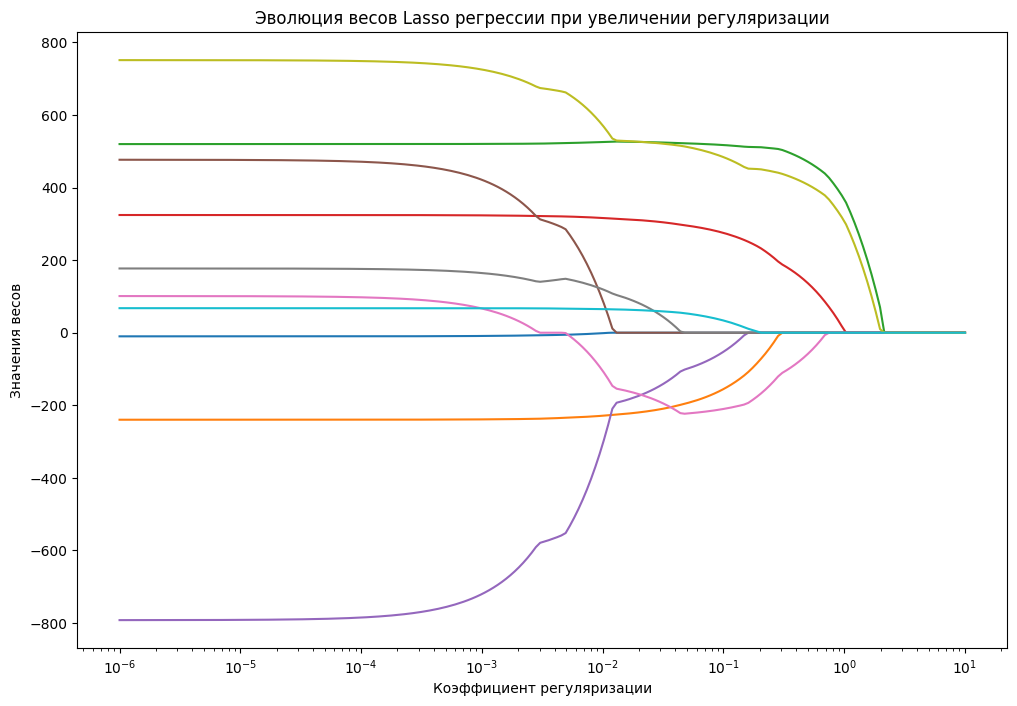

In [3]:
a = 1e-6
alpha_linspace = np.logspace(-6, 1, 200)
coefficients_history = []

for alpha in alpha_linspace:
    lm = Lasso(alpha=alpha, max_iter=10000)
    lm.fit(X, y)
    coefficients_history.append(lm.coef_)

coefficients_history = np.array(coefficients_history)

plt.figure(figsize=(12, 8))

for i in range(coefficients_history.shape[1]):
    plt.semilogx(alpha_linspace, coefficients_history[:, i])

plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Значения весов')
plt.title('Эволюция весов Lasso регрессии при увеличении регуляризации')
plt.show()

Фитил признаками)))))

Kfold N-1 учат, 1 тестирует, потом усредняем


In [54]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def generate_data(n_samples=100, noise_level=1):
    np.random.seed(42)
    x = np.linspace(-3, 3, n_samples)
    func = -3*x + 3*np.exp(x)
    noise = np.random.normal(0, noise_level, n_samples)
    y_true = func + noise

    X = np.column_stack([
        np.ones(n_samples),  # bias term
        -x,
        np.sin(3*x),
        np.exp(x),
        np.cos(x)
    ])
    return X, y_true, x

def make_L1_regression_grad_descent_iteration(X, y, w, mu, alpha):
    n_samples = X.shape[0]
    grad_mse = 2 * X.T @ (X @ w - y) / n_samples
    grad_l1 = mu * np.sign(w) 
    grad = grad_mse + grad_l1
    w_new = w - alpha * grad
    return w_new

def L1_regression_grad_descent(X, y, mu, alpha, n_iterations=1000, tol=1e-6, 
                              jump_prob=0.05, jump_scale=0.8):
    np.random.seed(42)
    w = np.random.randn(X.shape[1]) * 0.1 
    
    losses = []
    best_w = w.copy()
    best_loss = float('inf')
    
    for i in range(n_iterations):
        w_old = w.copy()
        
        w = make_L1_regression_grad_descent_iteration(X, y, w, mu, alpha)
        
        if np.random.random() < jump_prob:
            jump = np.random.randn(X.shape[1]) * jump_scale
            w_jump = w + jump
            
            current_loss = np.mean((X @ w - y)**2) + mu * np.sum(np.abs(w))
            jump_loss = np.mean((X @ w_jump - y)**2) + mu * np.sum(np.abs(w_jump))
            
            if jump_loss < current_loss:
                w = w_jump

        mse_loss = np.mean((X @ w - y)**2)
        l1_loss = mu * np.sum(np.abs(w))
        total_loss = mse_loss + l1_loss
        losses.append(total_loss)
        
        if total_loss < best_loss:
            best_loss = total_loss
            best_w = w.copy()

        if np.linalg.norm(w - w_old) < tol:
            break
    
    return best_w, losses, i + 1

def cross_validate_L1_regression(X, y, mu_values, alpha_values, n_folds=5, n_iterations=1000):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    best_mu = None
    best_alpha = None
    best_mse = float('inf')
    best_weights = None
    
    for mu in mu_values:
        for alpha in alpha_values:
            fold_mses = []
            fold_weights = []
            
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                w, losses, n_iters = L1_regression_grad_descent(
                    X_train, y_train, mu, alpha, n_iterations
                )
                
                y_pred = X_val @ w
                mse = mean_squared_error(y_val, y_pred)
                
                fold_mses.append(mse)
                fold_weights.append(w)
            
            mean_mse = np.mean(fold_mses)
            mean_weights = np.mean(fold_weights, axis=0)
            
            if mean_mse < best_mse:
                best_mse = mean_mse
                best_mu = mu
                best_alpha = alpha
                best_weights = mean_weights
    return best_weights, best_mse, best_mu, best_alpha

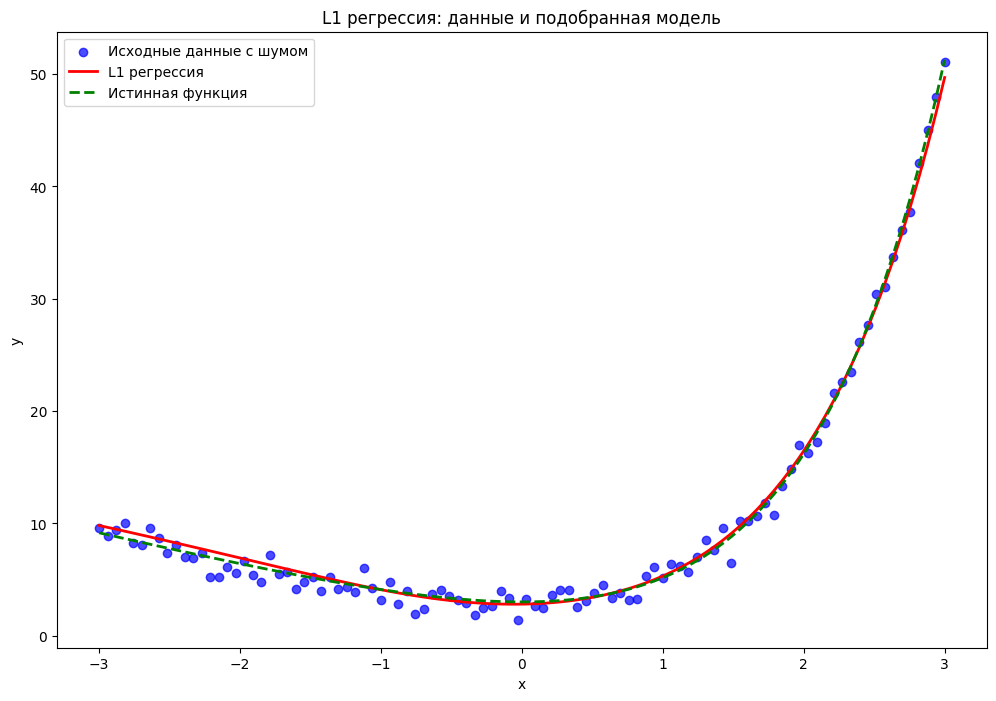

In [57]:
X, y, x = generate_data(100, 0.9)

mu_values = np.logspace(-10, 1, 15)
alpha_values = np.logspace(-10, -4, 15)

best_w, mse, best_mu, best_alpha = cross_validate_L1_regression(X, y, mu_values, alpha_values, n_folds=3)

y_pred = X @ best_w

import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 8))

plt.scatter(x, y, alpha=0.7, label='Исходные данные с шумом', color='blue')

plt.plot(x, y_pred, color='red', linewidth=2, label='L1 регрессия')

true_func = -3*x + 3*np.exp(x)
plt.plot(x, true_func, color='green', linestyle='--', linewidth=2, label='Истинная функция')

plt.xlabel('x')
plt.ylabel('y')
plt.title('L1 регрессия: данные и подобранная модель')
plt.legend()
plt.show()

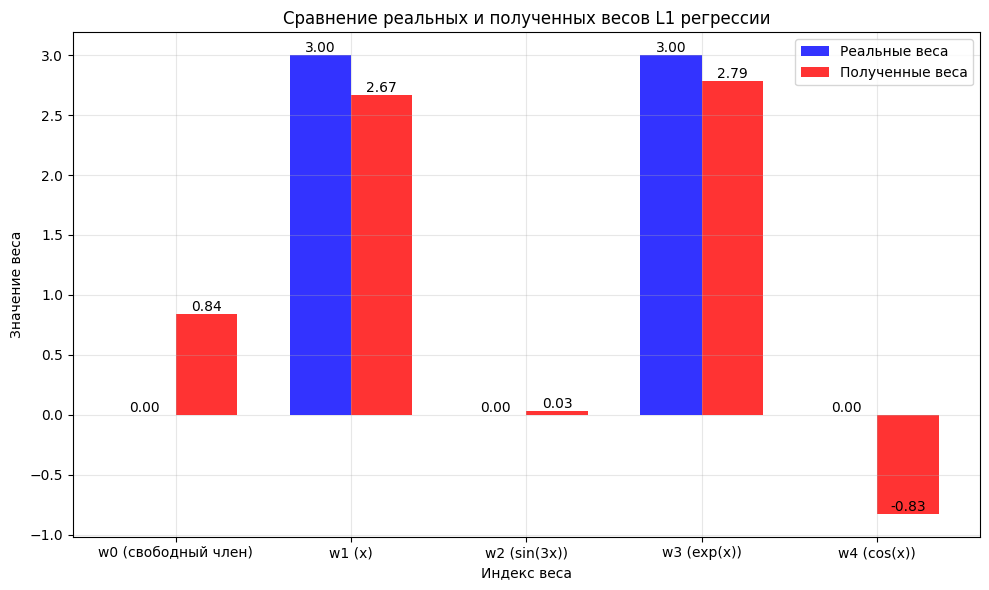

In [58]:
real_w = np.array([0, 3, 0, 3, 0])

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
x_pos = np.arange(len(real_w))

bars1 = ax.bar(x_pos - bar_width/2, real_w, bar_width, 
               label='Реальные веса', alpha=0.8, color='blue')
bars2 = ax.bar(x_pos + bar_width/2, best_w, bar_width, 
               label='Полученные веса', alpha=0.8, color='red')

ax.set_xlabel('Индекс веса')
ax.set_ylabel('Значение веса')
ax.set_title('Сравнение реальных и полученных весов L1 регрессии')
ax.set_xticks(x_pos)
ax.set_xticklabels(['w0 (свободный член)', 'w1 (x)', 'w2 (sin(3x))', 'w3 (exp(x))', 'w4 (cos(x))'])
ax.legend()
ax.grid(True, alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [1]:
def generate_hat_function(n_samples=200, noise_level=0.2):
    np.random.seed(42)
    x = np.linspace(-3, 3, n_samples)
    y_true = np.zeros_like(x)
    mask = np.abs(x) <= 2
    y_true[mask] = np.exp(-1/(1+(x[mask])**2))
    noise = np.random.normal(0, noise_level, n_samples)
    y = y_true + noise
    return x, y, y_true

def create_cosine_features(x, n_cosines):
    features = [np.ones_like(x), x]
    for i in range(1, n_cosines + 1):
        features.append(np.cos(i * x))
    return np.column_stack(features)

def make_L1_regression_grad_descent_iteration(X, y, w, mu, alpha):
    n_samples = X.shape[0]
    grad_mse = 2 * X.T @ (X @ w - y) / n_samples
    grad_l1 = mu * np.sign(w)
    grad = grad_mse + grad_l1
    w_new = w - alpha * grad
    return w_new

def L1_regression_grad_descent(X, y, mu, alpha, n_iterations=1000, tol=1e-6):
    np.random.seed(42)
    w = np.random.randn(X.shape[1]) * 0.1
    losses = []
    for i in range(n_iterations):
        w_old = w.copy()
        w = make_L1_regression_grad_descent_iteration(X, y, w, mu, alpha)
        mse_loss = np.mean((X @ w - y)**2)
        l1_loss = mu * np.sum(np.abs(w))
        total_loss = mse_loss + l1_loss
        losses.append(total_loss)
        if np.linalg.norm(w - w_old) < tol:
            break
    return w, losses, i + 1

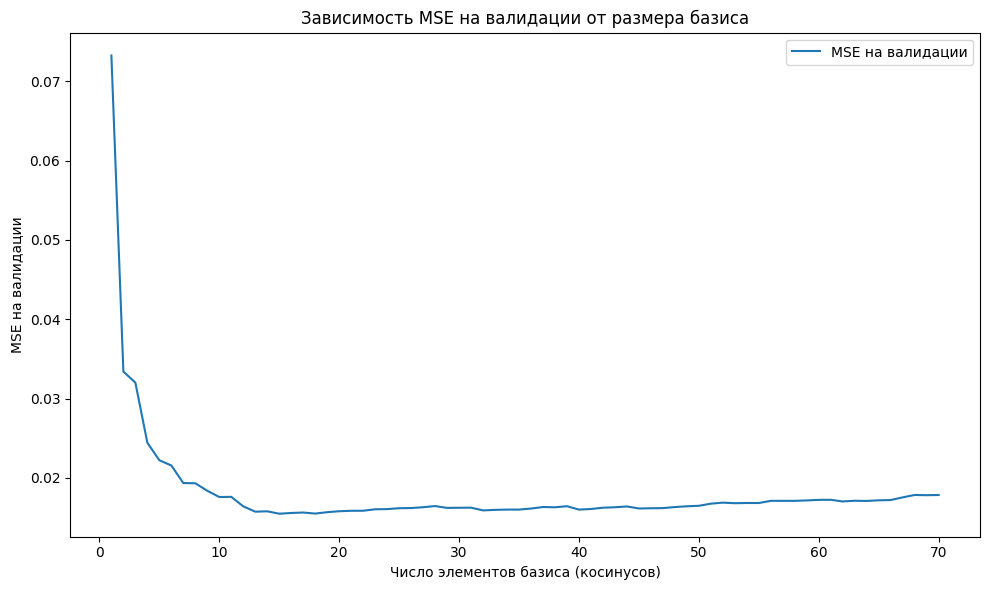

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def kfold_cross_validation_mse(x, y, n_cosines_range, mu=0.01, alpha=0.01, n_folds=5):
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    
    cv_mse_scores = []
    
    for n_cosines in n_cosines_range:
        fold_mse_scores = []
        
        X = create_cosine_features(x, n_cosines)
        
        for train_idx, val_idx in kf.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            w, losses, n_iters = L1_regression_grad_descent(X_train, y_train, mu, alpha)
            y_pred = X_val @ w
            mse = mean_squared_error(y_val, y_pred)
            fold_mse_scores.append(mse)
        
        cv_mse_scores.append(np.mean(fold_mse_scores))
    
    return cv_mse_scores

x, y, y_true = generate_hat_function(n_samples=200, noise_level=0.1)

n_cosines_range = range(1, 71)

cv_mse_values = kfold_cross_validation_mse(x, y, n_cosines_range, mu=0.01, alpha=0.01, n_folds=5)

best_idx = np.argmin(cv_mse_values)
best_cosines = n_cosines_range[best_idx]
best_mse = cv_mse_values[best_idx]

plt.figure(figsize=(10, 6))
plt.plot(n_cosines_range, cv_mse_values, label='MSE на валидации')

plt.xlabel('Число элементов базиса (косинусов)')
plt.ylabel('MSE на валидации')
plt.title('Зависимость MSE на валидации от размера базиса')
plt.legend()

plt.tight_layout()
plt.show()